In [1]:
import pickle
import matplotlib.pyplot as plt

In [2]:
import numpy as np
circ_type = "Heisenberg"
method = "leap"
tol = 1
ALL_Ms = [10, 20, 40, 80, 100, 200, 400, 600, 800, 1000, 2000, 4000, 6000, 8000, 10000]
TEST_Ms = [10, 20, 40, 80, 100, 200, 400, 600, 800, 1000]

def get_data(circ_type, method, tol):
    bias_dists = []
    vars = []
    covars = []
    # e1s = []
    for M in TEST_Ms:
        ensemble_dict = pickle.load(open(f"{circ_type}_{method}_{tol}_{M}.data", "rb"))
        bias_dists.append(ensemble_dict["final_bias_dist"])
        vars.append(ensemble_dict["final_var"])
        # covars.append(ensemble_dict["final_covar"])
        covars.append(np.abs(np.mean((ensemble_dict["covariances"]))))

    return bias_dists, vars, covars

biases, vars, covars = get_data(circ_type, method, tol)



In [3]:
from bqskit import Circuit
if circ_type == "TFIM":
    initial_circ = Circuit.from_file("ensemble_benchmarks/tfim_3.qasm")
    # target = np.loadtxt("/pscratch/sd/j/jkalloor/bqskit/ensemble_benchmarks/tfim_4-1.unitary", dtype=np.complex128)
elif circ_type == "Heisenberg":
    initial_circ = Circuit.from_file("ensemble_benchmarks/heisenberg_3.qasm")
    # target = np.loadtxt("/pscratch/sd/j/jkalloor/bqskit/ensemble_benchmarks/tfim_4-1.unitary", dtype=np.complex128)
elif circ_type == "Heisenberg_7":
    initial_circ = Circuit.from_file("/pscratch/sd/j/jkalloor/bqskit/ensemble_benchmarks/heisenberg7.qasm")
elif circ_type == "Hubbard":
    initial_circ = Circuit.from_file("/pscratch/sd/j/jkalloor/bqskit/ensemble_benchmarks/hubbard_4.qasm")
else:
    target = np.loadtxt("ensemble_benchmarks/qite_3.unitary", dtype=np.complex128)
    initial_circ = Circuit.from_unitary(target)

target = initial_circ.get_unitary()

In [4]:
import multiprocessing as mp
from bqskit import Circuit
from bqskit.qis import UnitaryMatrix
import numpy as np
import glob

# Store approximate solutions
dir = f"ensemble_approx_circuits_frobenius/{method}/{circ_type}/{tol}/*.pickle"

def get_circ_unitary(circ_file):
    circ: Circuit = pickle.load(open(circ_file, "rb"))
    return circ.get_unitary()

def get_upperbound_error_mean(unitaries: list[UnitaryMatrix], target):
    np_uns = [u.numpy for u in unitaries]
    mean = np.mean(np_uns, axis=0)
    errors = [u.get_frobenius_distance(target) for u in unitaries]

    max_error = np.mean(errors)
    max_variance = np.mean([u.get_frobenius_distance(mean) for u in unitaries])
    return np.sqrt(max_error), np.sqrt(max_variance), mean

print(dir)

circ_files = glob.glob(dir)

print(len(circ_files))

with mp.Pool() as pool:
    all_utries = pool.map(get_circ_unitary, circ_files)

print("------------------")
full_e1, full_e2, true_mean = get_upperbound_error_mean(all_utries, target)

ensemble_approx_circuits_frobenius/leap/Heisenberg/2/*.pickle
10056


------------------


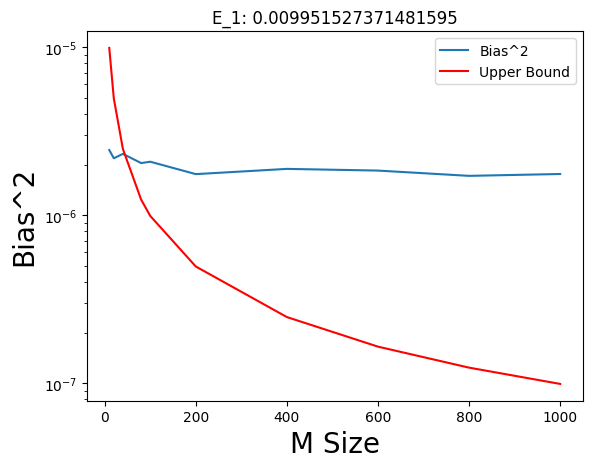

In [5]:
fig, axes = plt.subplots(1, 1)

error_bounds = [full_e1 ** 2 / m for m in TEST_Ms]

axes.plot(TEST_Ms, biases, label="Bias^2")
axes.plot(TEST_Ms, error_bounds, c= "red", label="Upper Bound")
axes.set_xlabel("M Size", fontdict={"size": 20})
axes.set_ylabel("Bias^2", fontdict={"size": 20})
axes.set_title(f"E_1: {full_e1}")
axes.legend()
axes.set_yscale("log")
# axes.axhline(full_e1 ** 2 / M, c="red")
# axes.axhline(final_bias, c="blue")
# axes.axhline(full_e1 ** 4, c="red")

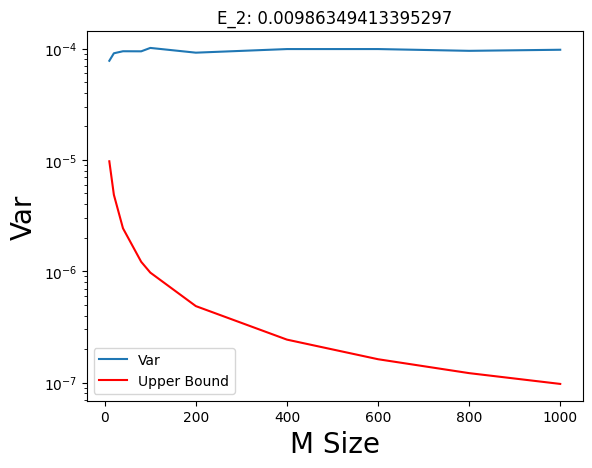

In [6]:
fig, axes = plt.subplots(1, 1)

var_error_bounds = [full_e2 ** 2 / m for m in TEST_Ms]

axes.plot(TEST_Ms, vars, label="Var")
axes.plot(TEST_Ms, var_error_bounds, c= "red", label="Upper Bound")
axes.set_xlabel("M Size", fontdict={"size": 20})
axes.set_ylabel("Var", fontdict={"size": 20})
axes.set_title(f"E_2: {full_e2}")
axes.legend()
axes.set_yscale("log")
# axes.axhline(full_e1 ** 2 / M, c="red")
# axes.axhline(final_bias, c="blue")
# axes.axhline(full_e1 ** 4, c="red")

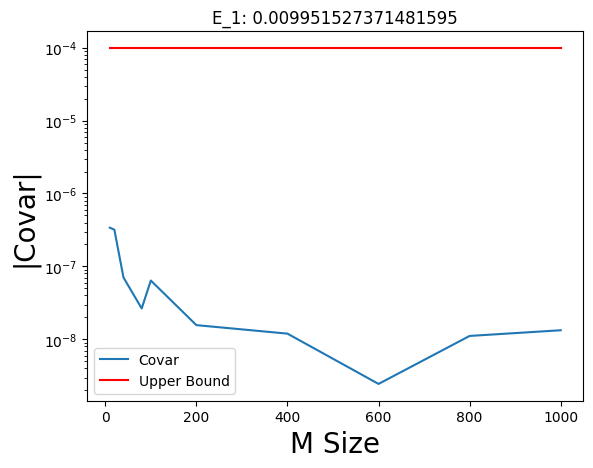

In [7]:
fig, axes = plt.subplots(1, 1)

covar_error_bounds = [full_e1 ** 2 for m in TEST_Ms]

axes.plot(TEST_Ms, covars, label="|Covar|")
axes.plot(TEST_Ms, covar_error_bounds, c= "red", label="Upper Bound")
axes.set_xlabel("M Size", fontdict={"size": 20})
axes.set_ylabel("|Covar|", fontdict={"size": 20})
axes.set_title(f"E_1: {full_e1}")
axes.legend()
axes.set_yscale("log")

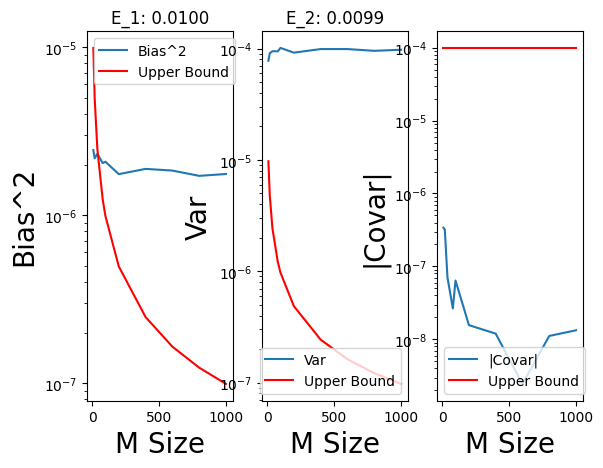

In [11]:
# All 3

fig, axes = plt.subplots(1, 3)

covar_error_bounds = [full_e1 ** 2 for m in TEST_Ms]

axes[0].plot(TEST_Ms, biases, label="Bias^2")
axes[0].plot(TEST_Ms, error_bounds, c= "red", label="Upper Bound")
axes[0].set_xlabel("M Size", fontdict={"size": 20})
axes[0].set_ylabel("Bias^2", fontdict={"size": 20})
axes[0].set_title(f"E_1: {full_e1:0.4f}")
axes[0].legend()
axes[0].set_yscale("log")


axes[1].plot(TEST_Ms, vars, label="Var")
axes[1].plot(TEST_Ms, var_error_bounds, c= "red", label="Upper Bound")
axes[1].set_xlabel("M Size", fontdict={"size": 20})
axes[1].set_ylabel("Var", fontdict={"size": 20})
axes[1].set_title(f"E_2: {full_e2:0.4f}")
axes[1].legend()
axes[1].set_yscale("log")

axes[2].plot(TEST_Ms, covars, label="|Covar|")
axes[2].plot(TEST_Ms, covar_error_bounds, c= "red", label="Upper Bound")
axes[2].set_xlabel("M Size", fontdict={"size": 20})
axes[2].set_ylabel("|Covar|", fontdict={"size": 20})
# axes[2].set_title(f"E_1: {full_e1:0.4f}")
axes[2].legend()
axes[2].set_yscale("log")